In [5]:
!pwd

/home/aurelien/formation_openclassrooms/projet_6/product-text-image-classification/notebooks


In [ ]:
import requests
import pandas as pd

def safe_first(*values):
    """Return the first non-empty value among candidates."""
    for v in values:
        if v is None:
            continue
        if isinstance(v, str) and v.strip() == "":
            continue
        return v
    return None

def fetch_openfoodfacts_products(query: str, page_size: int = 50):
    url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": query,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": page_size,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    return data.get("products", [])

def map_to_required_fields(p: dict) -> dict:
    """
    Map OpenFoodFacts product JSON -> required CSV columns:
    foodId, label, category, foodContentsLabel, image
    """
    food_id = p.get("code")

    label = safe_first(
        p.get("product_name_fr"),
        p.get("product_name"),
        p.get("generic_name_fr"),
        p.get("generic_name"),
    )

    category = safe_first(
        p.get("categories"),
        ", ".join(p.get("categories_tags", [])) if p.get("categories_tags") else None,
    )

    food_contents_label = safe_first(
        p.get("ingredients_text_fr"),
        p.get("ingredients_text"),
        p.get("ingredients_text_with_allergens_fr"),
        p.get("ingredients_text_with_allergens"),
    )

    image = safe_first(
        p.get("image_front_url"),
        p.get("image_url"),
        p.get("image_front_small_url"),
    )

    return {
        "foodId": food_id,
        "label": label,
        "category": category,
        "foodContentsLabel": food_contents_label,
        "image": image,
    }

products = fetch_openfoodfacts_products("champagne", page_size=50)

rows = []
for p in products:
    row = map_to_required_fields(p)

    if row["foodId"] and row["label"] and row["image"]:
        rows.append(row)

    if len(rows) == 10:
        break

df_champagne = pd.DataFrame(rows, columns=["foodId", "label", "category", "foodContentsLabel", "image"])
df_champagne


,foodId,label,category,foodContentsLabel,image
0,3039820510250,Vivien Paille Lentilles vertes le paquet de 500 g,"Aliments et boissons à base de végétaux, Alime...",Lentilles vertes.,https://images.openfoodfacts.org/images/produc...
1,3292070010264,"Betteraves de Champagne & chèvre crémeux, poin...",Salted spreads,Pois chiches 44% - purée de betterave rouge 37...,https://images.openfoodfacts.org/images/produc...
2,3113934004147,Canard Duchêne,"Boissons, Boissons alcoolisées, Vins, Vins eff...",Pinots et de Chardonnay,https://images.openfoodfacts.org/images/produc...
3,4820097815556,Splashes of champagne,None,None,https://images.openfoodfacts.org/images/produc...
4,4056489843696,Rillettes de homard au cognac,"Seafood, Fishes and their products, Fish prepa...","Chair de homard américain 49%, huile de colza,...",https://images.openfoodfacts.org/images/produc...
5,3760091726964,Lentilles roses bio,"Aliments et boissons à base de végétaux,Alimen...",Lentilles,https://images.openfoodfacts.org/images/produc...
6,3114080034057,Champagne rosé,"Bebidas, Bebidas alcohólicas, Vinos, Vinos esp...",None,https://images.openfoodfacts.org/images/produc...
7,3185370729960,Br МОЁ HANDON MOET & CHANDON CHAMPAGNE IMPERIA...,"Getränke und Getränkezubereitungen, Getränke, ...",IMPERIAL LOOK BEHIND THE SCENES OF OUR MAISON ...,https://images.openfoodfacts.org/images/produc...
8,3049610004104,Veuve Clicquot Champagne Ponsardin Brut,"Boissons et préparations de boissons, Boissons...",Champagne,https://images.openfoodfacts.org/images/produc...
9,3282946015837,Nicolas Feuillatte,"Boissons, Boissons alcoolisées, Vins, Vins fra...","Champagne, Contient des _sulfites_",https://images.openfoodfacts.org/images/produc...


In [ ]:
def check_image_url(url: str, timeout=10):
    if not isinstance(url, str) or not url.strip():
        return {"ok": False, "status": None}
    try:
        r = requests.head(url, timeout=timeout, allow_redirects=True)
        if r.status_code == 405:  
            r = requests.get(url, timeout=timeout, stream=True, allow_redirects=True)
        return {"ok": (200 <= r.status_code < 300), "status": r.status_code}
    except Exception:
        return {"ok": False, "status": None}

checks = []
for i, row in df_champagne.iterrows():
    res = check_image_url(row["image"])
    checks.append({"foodId": row["foodId"], "label": row["label"], "image": row["image"], **res})

df_checks = pd.DataFrame(checks)
df_checks

,foodId,label,image,ok,status
0,3039820510250,Vivien Paille Lentilles vertes le paquet de 500 g,https://images.openfoodfacts.org/images/produc...,True,200
1,3292070010264,"Betteraves de Champagne & chèvre crémeux, poin...",https://images.openfoodfacts.org/images/produc...,True,200
2,3113934004147,Canard Duchêne,https://images.openfoodfacts.org/images/produc...,True,200
3,4820097815556,Splashes of champagne,https://images.openfoodfacts.org/images/produc...,True,200
4,4056489843696,Rillettes de homard au cognac,https://images.openfoodfacts.org/images/produc...,True,200
5,3760091726964,Lentilles roses bio,https://images.openfoodfacts.org/images/produc...,True,200
6,3114080034057,Champagne rosé,https://images.openfoodfacts.org/images/produc...,True,200
7,3185370729960,Br МОЁ HANDON MOET & CHANDON CHAMPAGNE IMPERIA...,https://images.openfoodfacts.org/images/produc...,True,200
8,3049610004104,Veuve Clicquot Champagne Ponsardin Brut,https://images.openfoodfacts.org/images/produc...,True,200
9,3282946015837,Nicolas Feuillatte,https://images.openfoodfacts.org/images/produc...,True,200


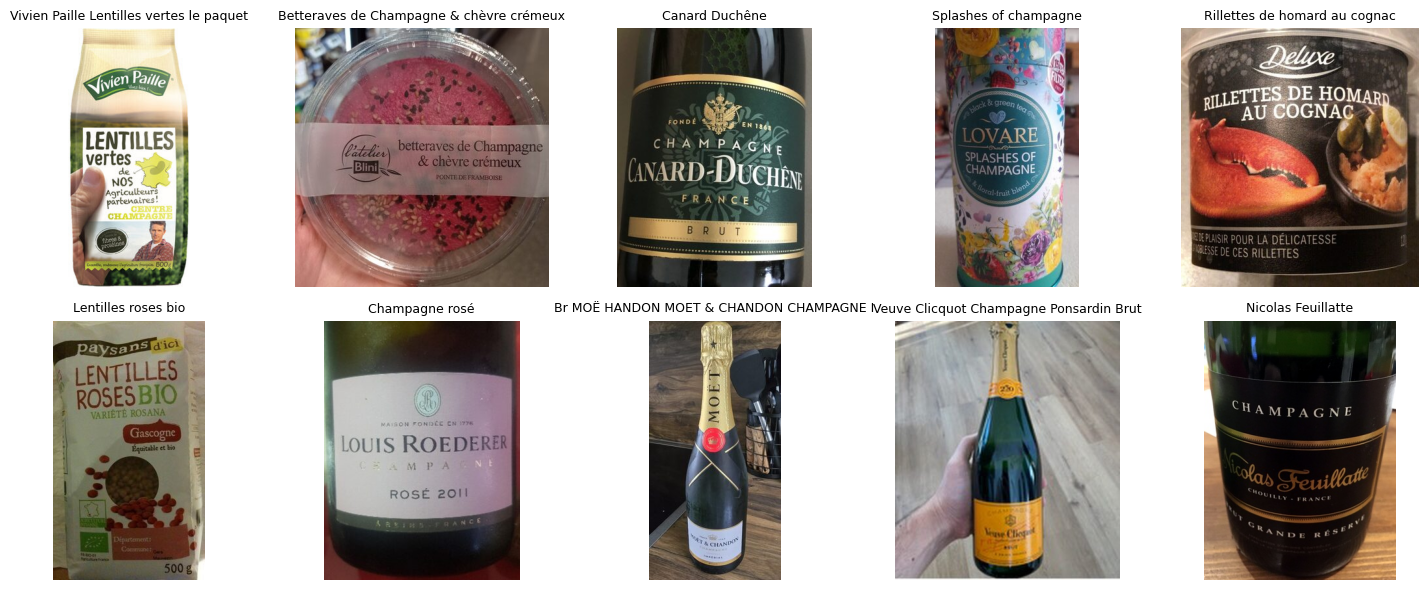

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def show_images_from_df(df, image_col="image", title_col="label", n_cols=5, figsize=(15, 6)):
    urls = df[image_col].tolist()
    titles = df[title_col].tolist()

    n = len(urls)
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, url, title in zip(axes, urls, titles):
        try:
            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            ax.imshow(img)
            ax.set_title(title[:40], fontsize=9)
        except Exception:
            ax.text(0.5, 0.5, "Image non disponible", ha="center", va="center")
        ax.axis("off")

    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images_from_df(df_champagne)


In [3]:
output = "../data/champagne_openfoodfacts.csv"
df_champagne.to_csv(output, index=False)
print("Saved:", output)


Saved: ../data/champagne_openfoodfacts.csv
